In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator
import os
#This folder conatins the logs of the Unity simulation and therefore the number of gates hitten, time...
all_data_foler = '..\\data_analysis\\data_analysis\\UnityLogs'
subjects_folders = [os.path.join(all_data_foler, o) for o in os.listdir(all_data_foler) if os.path.isdir(os.path.join(all_data_foler,o)) and 'Final' in o]

In [2]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom')

In [3]:
def get_all_data(data):
    dict_all_data = {}
    new_keys = []
    number_data = len(data['allLogs'])
    keys = list(data['allLogs'][0].keys())
    for key in keys:
        if type(data['allLogs'][0][key]) == float:
            dict_all_data[key] = []
            new_keys.append(key)
        elif type(data['allLogs'][0][key]) == dict:
            for subKey in data['allLogs'][0][key].keys():
                dict_all_data[key+'_'+subKey] = []
                new_keys.append(key+'_'+subKey)
        else:
            if type(data['allLogs'][0][key][0]) == int or type(data['allLogs'][0][key][0])== float:
                for subKey in range(len(data['allLogs'][0][key])):
                    dict_all_data[key+'_'+str(subKey)] = []
                    new_keys.append(key+'_'+str(subKey))
            elif type(data['allLogs'][0][key][0]) == dict:
                for subKey in range(len(data['allLogs'][0][key])):
                    for subsubKey in data['allLogs'][0][key][0].keys():
                        dict_all_data[key+'_'+str(subKey)+'_'+subsubKey] = []
                        new_keys.append(key+'_'+str(subKey)+'_'+subsubKey)
            else:
                print(type(data['allLogs'][0][key][0]))
                print(data['allLogs'][0][key])

    for i in range(number_data):
        current_data = data['allLogs'][i]
        for key in keys:
            if type(data['allLogs'][0][key]) == float:
                dict_all_data[key].append(current_data[key])
            elif type(data['allLogs'][0][key]) == dict:
                for subKey in data['allLogs'][0][key].keys():
                    dict_all_data[key+'_'+subKey].append(current_data[key][subKey])
            else:
                if type(data['allLogs'][0][key][0]) == int or type(data['allLogs'][0][key][0])== float:
                    for subKey in range(len(data['allLogs'][0][key])):
                        dict_all_data[key+'_'+str(subKey)].append(current_data[key][subKey])
                elif type(data['allLogs'][0][key][0]) == dict:
                    for subKey in range(len(data['allLogs'][0][key])):
                        for subsubKey in data['allLogs'][0][key][0].keys():
                            dict_all_data[key+'_'+str(subKey)+'_'+subsubKey].append(current_data[key][subKey][subsubKey])
                else:
                    print(type(data['allLogs'][0][key][0]))
                    print(data['allLogs'][0][key])
    return(dict_all_data,new_keys)

In [1]:
def get_metrics(subject_folder,device):
    # This returns for each subject / device the number of gates collided and the time spent between each gate
    # Antoher technique is used instead of this one, so this function isn't used
    leap_files = [f for f in os.listdir(subject_folder) if 'Leap' in f]
    remote_files = [f for f in os.listdir(subject_folder) if 'Remote' in f]
    value_time_gate = []
    number_gate_collided = []
    if device == 'leap':
        files = leap_files
    else:
        files = remote_files
    for f in files:
        file = os.path.join(subject_folder,f)
        with open(file) as json_file:
            data = json.load(json_file)

        number_data = len(data['allLogs'])
        samples = list(range(number_data))

        dict_all_data,new_keys = get_all_data(data)
        for key in new_keys:
            list_values = np.array(dict_all_data[key])
            if 'differentialTime' in key:
                peaks, _ = find_peaks(list_values)
                peaks = [int(p) for p in peaks]
                if len(peaks) > 4:
                    ind_peaks = np.argsort(list_values[peaks])[-4:]
                    ind_peaks = [int(p) for p in ind_peaks]
                    peaks = np.array(peaks)[ind_peaks]
                plt.plot(peaks, list_values[peaks], "p")
                value_time_gate.append(list_values[np.sort(peaks)])
                plt.plot(samples,list_values,label=key)
                plt.grid()
                plt.legend()
                plt.show()
        gates_n = (dict_all_data['collision_0'][-1]==1)*1.0 + (dict_all_data['collision_1'][-1]==1)*1.0 + (dict_all_data['collision_2'][-1]==1)*1.0 + (dict_all_data['collision_3'][-1]==1)*1.0
        number_gate_collided.append(4-gates_n)
    return(value_time_gate,number_gate_collided)

In [5]:
def get_alternative_differential_time(subject_folder,device):
    # This returns for each subject / device the number of gates collided and the time spent between each gate
    leap_files = [f for f in os.listdir(subject_folder) if 'Leap' in f]
    remote_files = [f for f in os.listdir(subject_folder) if 'Remote' in f]
    value_time_gate = []
    number_gate_collided = []
    if device == 'leap':
        files = leap_files
    else:
        files = remote_files
    for f in files:
        file = os.path.join(subject_folder,f)
        with open(file) as json_file:
            data = json.load(json_file)
        number_data = len(data['allLogs'])
        samples = list(range(number_data))
        dict_all_data,new_keys = get_all_data(data)

        dict_all_data['absoluteTime'] = np.array(dict_all_data['absoluteTime']) - dict_all_data['absoluteTime'][0]
        times_gates = []
        # This processing deals with the issue of people passing through the same gate several time 
        # (the timer reset too much times and so there are too many peaks)
        # We only consider changes of gate on the major peaks
        for i in range(4):
            times_gates.append(dict_all_data['absoluteTime'][list(np.abs(dict_all_data['collision_'+str(i)])).index(1)])
            if i!=0:
                times_gates[-1] -= times_gates[-2]    # To have a diffrence between the two gates time
        if (np.array(times_gates)<0).any():
            print(times_gates)
            print(np.array(times_gates)<0)
            print("Invalid dataset for subject {} file {}".format(subject_folder,f))
        else:
            value_time_gate.append(times_gates)
        gates_n = (dict_all_data['collision_0'][-1]==1)*1.0 + (dict_all_data['collision_1'][-1]==1)*1.0 + (dict_all_data['collision_2'][-1]==1)*1.0 + (dict_all_data['collision_3'][-1]==1)*1.0

        number_gate_collided.append(4-gates_n)
    print(files, number_gate_collided)
    return(value_time_gate,number_gate_collided)

In [6]:
# Getting all the metrics

all_values_time_gate_leap = []
all_number_gate_collided_leap = []
for folder in subjects_folders:
    # print(folder)
    val_time,num_gates = get_alternative_differential_time(folder,'leap')
    all_values_time_gate_leap.append(np.array(val_time))
    all_number_gate_collided_leap.append(np.array(num_gates))
    
all_values_time_gate_remote = []
all_number_gate_collided_remote = []
for folder in subjects_folders:
    # print(folder)
    val_time,num_gates = get_alternative_differential_time(folder,'remote')
    all_values_time_gate_remote.append(np.array(val_time))
    all_number_gate_collided_remote.append(np.array(num_gates))

..\data_analysis\data_analysis\UnityLogs\Final_10_Position_Control
['Leap_2020_08_22_18_27_36.json', 'Leap_2020_08_22_18_30_16.json', 'Leap_2020_08_22_18_32_57.json', 'Leap_2020_08_22_18_34_22.json', 'Leap_2020_08_22_18_40_35.json'] [2.0, 2.0, 2.0, 2.0, 0.0]
..\data_analysis\data_analysis\UnityLogs\Final_1_Position_Control
['Leap_2020_07_21_09_07_39.json', 'Leap_2020_07_21_09_10_59.json', 'Leap_2020_07_21_09_12_10.json', 'Leap_2020_07_21_09_13_23.json', 'Leap_2020_07_21_09_14_32.json'] [0.0, 0.0, 0.0, 0.0, 0.0]
..\data_analysis\data_analysis\UnityLogs\Final_2_Position_Control
['Leap_2020_07_22_13_55_56.json', 'Leap_2020_07_22_13_58_23.json', 'Leap_2020_07_22_14_01_22.json', 'Leap_2020_07_22_14_03_56.json', 'Leap_2020_07_22_14_06_41.json'] [1.0, 2.0, 1.0, 1.0, 0.0]
..\data_analysis\data_analysis\UnityLogs\Final_3_Position_Control
['Leap_2020_07_23_08_47_55.json', 'Leap_2020_07_23_08_49_19.json', 'Leap_2020_07_23_08_51_17.json', 'Leap_2020_07_23_08_53_06.json', 'Leap_2020_07_23_08_54_42.

In [7]:
print(np.shape(all_values_time_gate_leap))
# 10 is the number of subjects
# 5 is the number of runs per subject
# 4 is the number of gates per run
value_time_gate_leap = np.mean(all_values_time_gate_leap,axis = 0)
print(np.shape(value_time_gate_leap))

number_gate_collided_leap = np.mean(all_number_gate_collided_leap,axis = 0)
number_gate_collided_leap_std = np.std(all_number_gate_collided_leap,axis = 0)

value_time_gate_remote = np.mean(all_values_time_gate_remote,axis = 0)
number_gate_collided_remote = np.mean(all_number_gate_collided_remote,axis = 0)
number_gate_collided_remote_std = np.std(all_number_gate_collided_remote,axis = 0)

(10, 5, 4)
(5, 4)


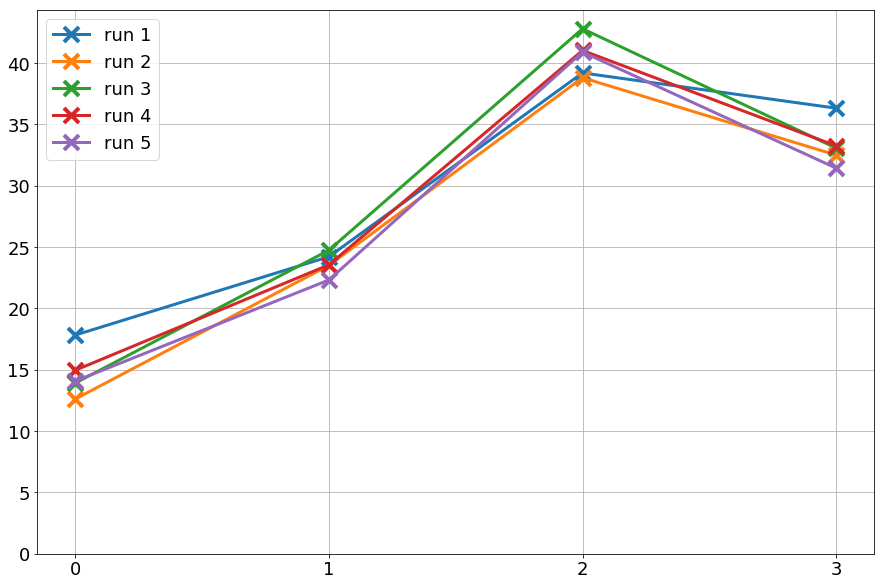

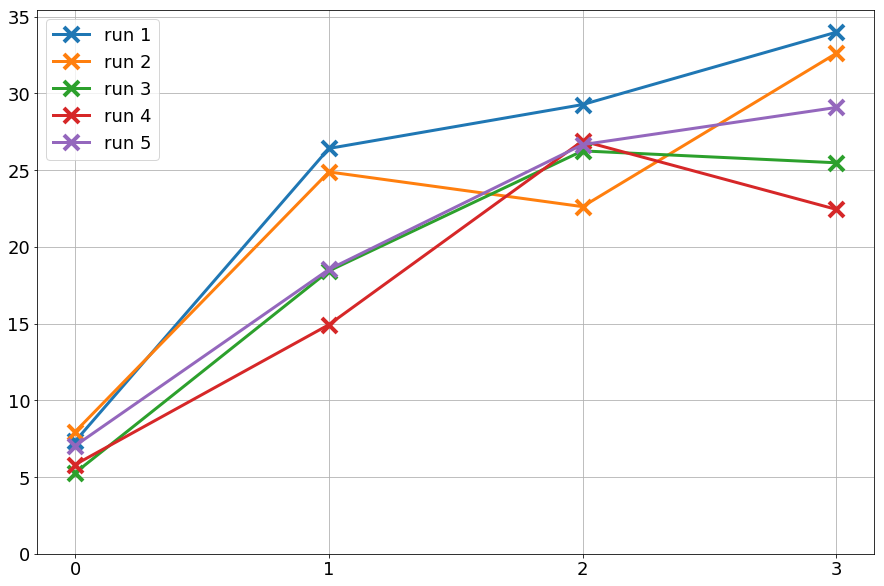

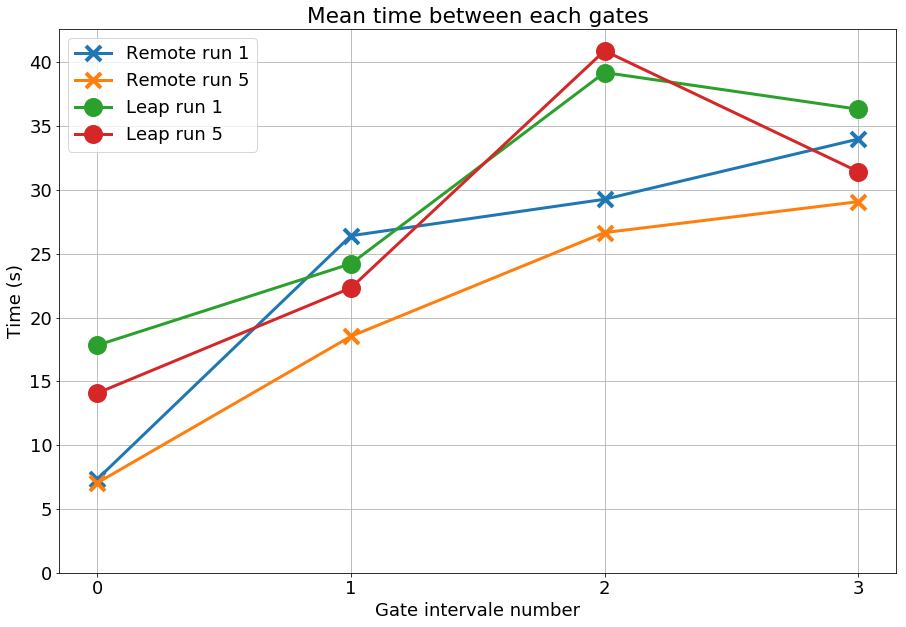

In [8]:
# Plots the time between each gates using a line plot 
# Not used anymore

plt.rcParams.update({'font.size': 18})
ax = plt.figure(figsize=(15,10)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for i,values in enumerate(value_time_gate_leap):
    ax.plot(list(range(len(values))),values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label="run {}".format(i+1))
ax.grid()
ax.set_ylim(ymin = 0)
ax.legend()
plt.show()

ax = plt.figure(figsize=(15,10)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for i,values in enumerate(value_time_gate_remote):
    ax.plot(list(range(len(values))),values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label="run {}".format(i+1))
ax.grid()
ax.set_ylim(ymin = 0)
ax.legend()
plt.show()


value_time_gate_remote_extrem_runs = np.vstack((value_time_gate_remote[0,:],value_time_gate_remote[4,:]))
value_time_gate_leap_extrem_runs = np.vstack((value_time_gate_leap[0,:],value_time_gate_leap[4,:]))

ax = plt.figure(figsize=(15,10)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for i,values in enumerate(value_time_gate_remote_extrem_runs):
    ax.plot(list(range(len(values))),values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label="Remote run {}".format(i*4+1))
for i,values in enumerate(value_time_gate_leap_extrem_runs):
    ax.plot(list(range(len(values))),values,marker='o',markersize=15,markeredgewidth=4,linewidth = 3,label="Leap run {}".format(i*4+1))
ax.grid()
ax.set_ylim(ymin = 0)
ax.legend()
ax.set_xlabel("Gate intervale number")
ax.set_ylabel("Time (s)")
ax.set_title("Mean time between each gates")
plt.show()

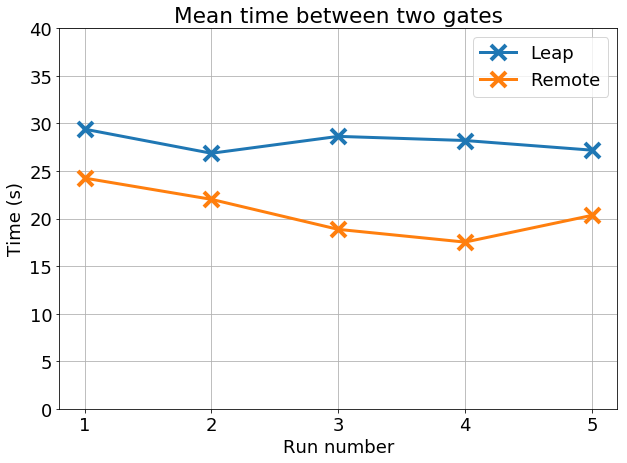

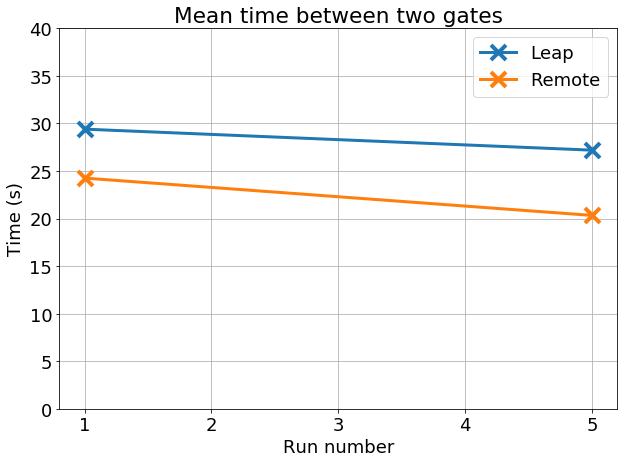

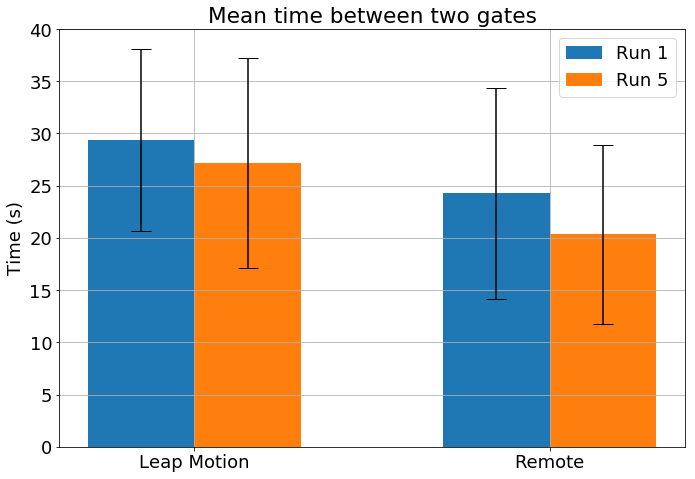

In [9]:
# Plots the same information as above but differently
# Not used anymore

plt.rcParams.update({'font.size': 18})
runs = list(range(1,6))
#runs = [runs[0],runs[-1]]
#plt.figure(figsize=(10,7))
ax = plt.figure(figsize=(10,7)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
values = np.mean(value_time_gate_leap, axis = 1)
#values = [values[0],values[-1]]
ax.plot(runs,values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label = 'Leap')
values = np.mean(value_time_gate_remote,axis = 1)
#values = [values[0],values[-1]]
ax.plot(runs,values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label = 'Remote')
ax.grid()
ax.set_ylim(0,40)
ax.legend()
ax.set_title("Mean time between two gates")
ax.set_xlabel("Run number")
ax.set_ylabel("Time (s)")
plt.show()


#### Plot only first and last
runs = list(range(1,6))
runs = [runs[0],runs[-1]]
ax = plt.figure(figsize=(10,7)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
values = np.mean(value_time_gate_leap, axis = 1)
values = [values[0],values[-1]]
ax.plot(runs,values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label = 'Leap')
values = np.mean(value_time_gate_remote,axis = 1)
values = [values[0],values[-1]]
ax.plot(runs,values,marker='x',markersize=15,markeredgewidth=4,linewidth = 3,label = 'Remote')
ax.grid()
ax.set_ylim(0,40)
ax.legend()
ax.set_title("Mean time between two gates")
ax.set_xlabel("Run number")
ax.set_ylabel("Time (s)")
plt.show()

#### BAR PLOT
runs = list(range(1,6))
runs = [runs[0],runs[-1]]

values = np.mean(value_time_gate_leap, axis = 1)
std = np.std(value_time_gate_leap, axis = 1)
values_leap = [values[0],values[-1]]
values_leap_std = [std[0],std[-1]]

values = np.mean(value_time_gate_remote,axis = 1)
std = np.std(value_time_gate_remote, axis = 1)
values_remote = [values[0],values[-1]]
values_remote_std = [std[0],std[-1]]

all_values = np.vstack((values_leap,values_remote))
values_run_1 = all_values[:,0]
values_run_5 = all_values[:,1]

all_values_std = np.vstack((values_leap_std,values_remote_std))
values_run_1_std = all_values_std[:,0]
values_run_5_std = all_values_std[:,1]

labels = ['Leap Motion', 'Remote']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, values_run_1, width, yerr = values_run_1_std, label='Run 1', capsize=10)
rects2 = ax.bar(x + width/2, values_run_5, width, yerr = values_run_5_std, label='Run 5', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Mean time between two gates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()

#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()

plt.show()

[]

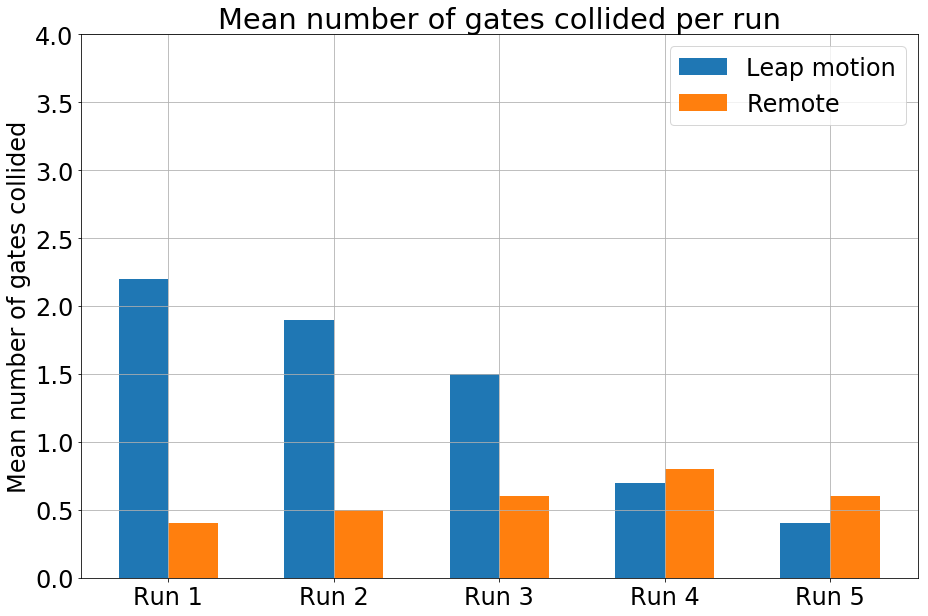

In [10]:
# Plots the mean number of gate collided per run

plt.rcParams.update({'font.size': 24})
labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, number_gate_collided_leap, width, label='Leap motion')#, yerr = number_gate_collided_leap_std)
rects2 = ax.bar(x + width/2, number_gate_collided_remote, width, label='Remote')#, yerr = number_gate_collided_remote_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean number of gates collided')
ax.set_title('Mean number of gates collided per run')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,4)
ax.legend()
plt.grid()
plt.plot()

In [11]:
# Box plots functions

from matplotlib.pylab import savefig

def bar_multi(vals, error = None, xlabels = '', xticks = None, yticks = None, xlim = None, ylim = None, ylabel = '', title = '', legend = '', normalize = False, colors = None, w= None, ax = None, save = False, where = None):
    print(colors)    
    if colors is None:
        colors = 'rgbkmyc'    
    def norm_list(l, M_all = None):        
        if M_all is None:
            M = [max(i) for i in l]
            M_all = max(M)        
        list_l_norm = l[:]        
        for idx, i in enumerate(l):
            print(i)
            list_l_norm[idx] = np.array(i)/M_all
            print(i)        
        l = list_l_norm        
        return [l, M_all]    # make list of lists if not
    
    if type(vals[0]) is not list:
        vals = [vals]
#        for i in np.arange(len(vals)):
#            vals[i] = [vals[i]]    
    n_ticks = len(vals[0])
    l_each = len(vals)    
    
    no_legend = False
    if legend == '':
        no_legend = True
        legend = [''] * l_each    
        
    if ax is None:
        ax = plt.subplot(111)    
    
    plt.title(title)
    ax.grid('on')    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")    
    
    if normalize:        
        [vals, M] = norm_list(vals)        
        
        if error is not None:
            [error, _] = norm_list(error, M)    
            
    x = np.arange(n_ticks) + 1
    if w is None:
        w = 0.3    
        
    bars = []    
    
    for count, i in enumerate(vals):
        if error is None:
            bars.append(ax.bar(x - w*l_each/2 + w*(count + 1/2), i, width=w,align='center', label = legend[count], color = colors[count], ecolor = colors[count]))
        else:
            bars.append(ax.bar(x - w*l_each/2 + w*(count + 1/2), i, yerr=error[count],width=w,align='center', label = legend[count], color = colors[count], ecolor = colors[count]))    
            
    if not no_legend:
        ax.legend()    
        
    plt.xticks(x, xlabels, axes=ax)    
    
    if xlim is not None:
        plt.xlim(xlim)    
    if ylim is not None:
        plt.xlim(ylim)
    if xticks is not None:
        plt.xticks(xticks)    
    if yticks is not None:
        plt.yticks(yticks)    
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    
    if save:
        savefig(where, bbox_inches='tight')    
        
    return ax

def boxplot_elegant(ax, data, position, c = 'b', whis = 1.5):    
    plt.boxplot(data, notch=None, positions = position, patch_artist=True,
                boxprops=dict(color=c, facecolor='none', linewidth=3),
                capprops=dict(color=c, linewidth=3),
                whiskerprops=dict(color=c, linewidth=3),
                flierprops=dict(color=c, markeredgecolor=c, linewidth=3),
                medianprops=dict(color=c, linewidth=3),
                whis = whis
                )
    
def make_fig_simple():
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    
    return [fig, ax]

def basic_box(data, col = 'b', tit = '', leg = False, labels = [], ax = None, save = False, where = None, y = '', xlim = None, ylim = None, xticks = None, yticks = None, whis = 1.5):    
    full = 1
    light = 0.6  
    low = 0
    c0 = np.array([low,low,full])
    c1 = np.array([light,light,full])
    c2 = np.array([full,low,low])   
    c3 = np.array([full,light,light])
    col = [c0, c1, c2, c3]    
    if ax is None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)       
    
    for idx, i in enumerate(data):         
        pos = 1+(idx)*0.5        
        boxplot_elegant(ax, i, [pos], col[idx], whis = whis)    
        
    #ax.yaxis.grid()
    #ax.xaxis.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)    
        
    plt.title(tit)    
    
    plt.xticks([1, 1.5, 2.0, 2.5], ['L1', 'L5', 'R1', 'R5'])    
    
    plt.xlim([0.8, 2.7])    
    
    plt.ylabel(y)    
    
    if leg:
        for idx,i in enumerate(labels):
            ax.scatter(0,0, color = col[idx], label = i)
            
        plt.legend(loc='lower left')
        # plt.legend()    
    if save:
        savefig(where, bbox_inches='tight')    
    
    return ax

(10, 5, 4)


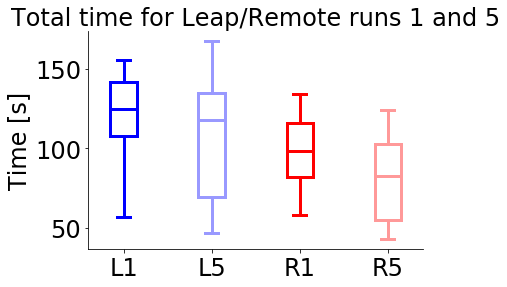

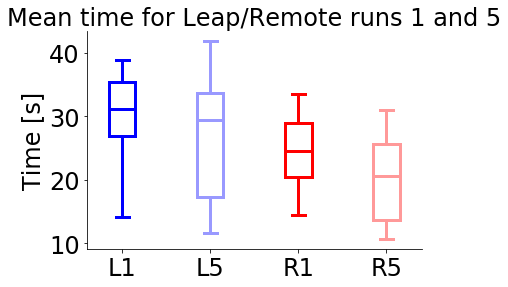

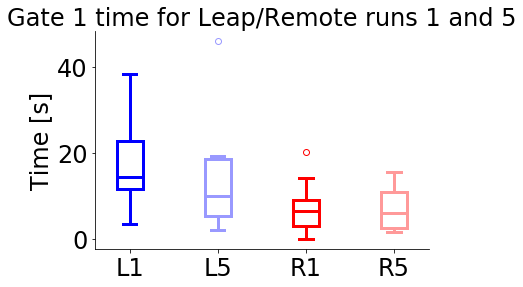

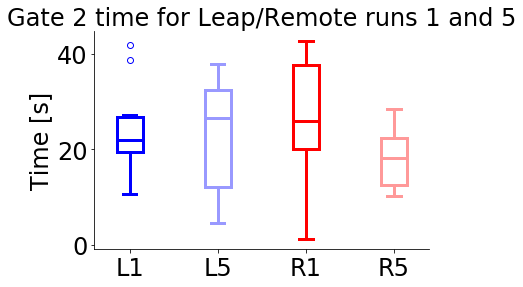

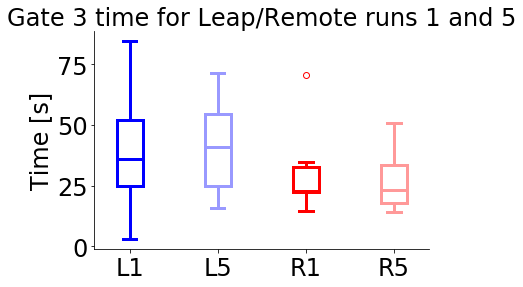

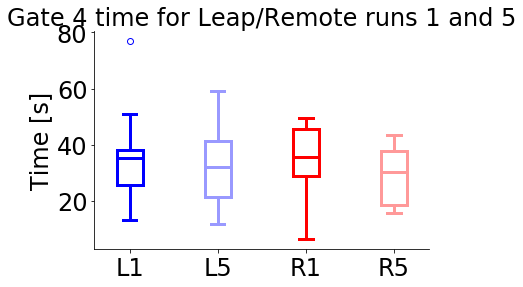

In [12]:
# Box plots 

import matplotlib.pyplot as plt

SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

all_values_time_gate_leap = np.array(all_values_time_gate_leap)
all_values_time_gate_remote = np.array(all_values_time_gate_remote)

all_subject_total_time_per_run_leap = np.sum(all_values_time_gate_leap,axis = 2)
all_subject_total_time_per_run_remote = np.sum(all_values_time_gate_remote,axis = 2)
all_subject_mean_time_per_run_leap = np.mean(all_values_time_gate_leap,axis = 2)
all_subject_mean_time_per_run_remote = np.mean(all_values_time_gate_remote,axis = 2)
print(np.shape(all_values_time_gate_leap))

data = np.array([all_subject_total_time_per_run_leap[:,0],all_subject_total_time_per_run_leap[:,-1],all_subject_total_time_per_run_remote[:,0],all_subject_total_time_per_run_remote[:,-1]])
ax = basic_box(data,tit = 'Total time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_total_time_grid.pdf")
plt.show()

data = np.array([all_subject_mean_time_per_run_leap[:,0],all_subject_mean_time_per_run_leap[:,-1],all_subject_mean_time_per_run_remote[:,0],all_subject_mean_time_per_run_remote[:,-1]])
ax = basic_box(data,tit = 'Mean time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_mean_time_grid.pdf")
plt.show()

# Gate 1
data = np.array([all_values_time_gate_leap[:,0,0],all_values_time_gate_leap[:,-1,0],all_values_time_gate_remote[:,0,0],all_values_time_gate_remote[:,-1,0]])
ax = basic_box(data,tit = 'Gate 1 time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_mean_time_grid.pdf")
plt.show()

# Gate 2
data = np.array([all_values_time_gate_leap[:,0,1],all_values_time_gate_leap[:,-1,1],all_values_time_gate_remote[:,0,1],all_values_time_gate_remote[:,-1,1]])
ax = basic_box(data,tit = 'Gate 2 time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_mean_time_grid.pdf")
plt.show()

# Gate 3
data = np.array([all_values_time_gate_leap[:,0,2],all_values_time_gate_leap[:,-1,2],all_values_time_gate_remote[:,0,2],all_values_time_gate_remote[:,-1,2]])
ax = basic_box(data,tit = 'Gate 3 time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_mean_time_grid.pdf")
plt.show()

# Gate 4
data = np.array([all_values_time_gate_leap[:,0,3],all_values_time_gate_leap[:,-1,3],all_values_time_gate_remote[:,0,3],all_values_time_gate_remote[:,-1,3]])
ax = basic_box(data,tit = 'Gate 4 time for Leap/Remote runs 1 and 5',labels = ['1','2','3','4'], y = 'Time [s]', save = True, where = "C:\\Users\\defoo\\Desktop\\EPFL_paper\\Figures\\time_task\\boxplot_mean_time_grid.pdf")
plt.show()